<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Endpoints300s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [44]:
dataset_e1 = load_dataset("anastasiafrosted/endpoint0_300", download_mode="force_redownload")
dataset_e2 = load_dataset("anastasiafrosted/endpoint1_300", download_mode="force_redownload")

df_1 = pd.DataFrame(dataset_e1['train'])
df_2 = pd.DataFrame(dataset_e2['train'])

# Ensure the `timestamp` column is in datetime format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/629k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25600 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/327k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22019 [00:00<?, ? examples/s]

In [45]:
data1 = df_1
data1 = data1.set_index("timestamp")
data2 = df_2
data2 = data2.set_index("timestamp")
freq='300s'

In [46]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data1 = data1["2022-12-20":origin]
valid_data1 = data1[origin:start]
test_data1 = data1[start:]

train_data2 = data2["2022-12-20":origin]
valid_data2 = data2[origin:start]
test_data2 = data2[start:]

# List of columns to drop
columns_to_drop = [
    'e_type_LSFProvider', 'e_type_CobaltProvider',
    'e_type_PBSProProvider', 'e_type_LocalProvider',
    'e_type_KubernetesProvider', 'e_type_SlurmProvider'
]
train_data1 = train_data1.drop(columns=columns_to_drop, errors='ignore')
valid_data1 = valid_data1.drop(columns=columns_to_drop, errors='ignore')
test_data1 = test_data1.drop(columns=columns_to_drop, errors='ignore')

train_data2 = train_data2.drop(columns=columns_to_drop, errors='ignore')
valid_data2 = valid_data2.drop(columns=columns_to_drop, errors='ignore')
test_data2 = test_data2.drop(columns=columns_to_drop, errors='ignore')

#### Scaling

In [47]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

In [48]:
# ENDPOINT 1:

# Per il dataset di training
scaled_train1 = train_data1.copy()
scaled_train1[scaled_train1.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data1[train_data1.columns.drop('avg_invocations_rate')]
)
train1 = scaled_train1

# Per il dataset di validazione
scaled_valid1 = valid_data1.copy()
scaled_valid1[scaled_valid1.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data1[valid_data1.columns.drop('avg_invocations_rate')]
)
valid1 = scaled_valid1

# Per il dataset di test
scaled_test1 = test_data1.copy()
scaled_test1[scaled_test1.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data1[test_data1.columns.drop('avg_invocations_rate')]
)
test1 = scaled_test1

In [49]:
# ENDPOINT 2:

# Per il dataset di training
scaled_train2 = train_data2.copy()
scaled_train2[scaled_train2.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data2[train_data2.columns.drop('avg_invocations_rate')]
)
train2 = scaled_train2

# Per il dataset di validazione
scaled_valid2 = valid_data2.copy()
scaled_valid2[scaled_valid2.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data2[valid_data2.columns.drop('avg_invocations_rate')]
)
valid2 = scaled_valid2

# Per il dataset di test
scaled_test2 = test_data2.copy()
scaled_test2[scaled_test2.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data2[test_data2.columns.drop('avg_invocations_rate')]
)
test2 = scaled_test2

#### Config (Parameters)

In [50]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 10

# Models

## Forecasting one-step-ahead

In [51]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [52]:
tr1 = train1['avg_invocations_rate']
vl1 = valid1['avg_invocations_rate']
ts1 = test1['avg_invocations_rate']

tr2 = train2['avg_invocations_rate']
vl2 = valid2['avg_invocations_rate']
ts2 = test2['avg_invocations_rate']

In [53]:
# ENDPOINT 1:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    tr1.to_numpy(),
    targets=tr1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    vl1.to_numpy(),
    targets=vl1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    ts1.to_numpy(),
    targets=ts1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [54]:
# ENDPOINT 2:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    tr2.to_numpy(),
    targets=tr2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    vl2.to_numpy(),
    targets=vl2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    ts2.to_numpy(),
    targets=ts2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
fit_and_evaluate(model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0012 - mae: 0.0383 - val_loss: 4.8353e-04 - val_mae: 0.0250
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 6.1891e-04 - mae: 0.0269 - val_loss: 3.5091e-04 - val_mae: 0.0198
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 5.1525e-04 - mae: 0.0236 - val_loss: 3.1483e-04 - val_mae: 0.0178
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 4.8092e-04 - mae: 0.0222 - val_loss: 2.9837e-04 - val_mae: 0.0170
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 4.6503e-04 - mae: 0.0215 - val_loss: 2.8939e-04 - val_mae: 0.0165
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.5272e-04 - mae: 0.0211 - val_loss: 2.8337e-04 - val_mae: 0.0162
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.4144e-04 - mae: 0.0207 - val_loss: 2.7671e-04 - val_mae: 0.0159
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 4.3379e-04 - mae: 0.0205 - val_loss: 2.7149e-04 - val_ma

15314.7391974926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


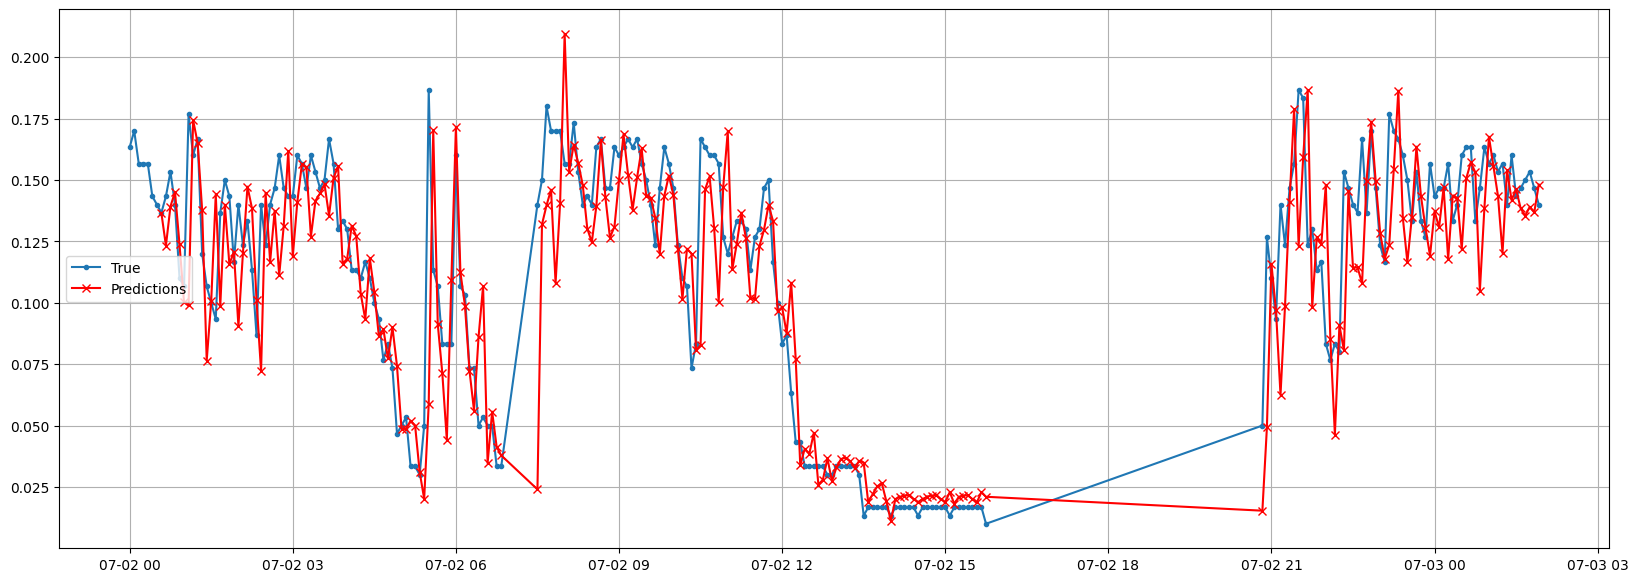

In [57]:
Y_pred = model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=test1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [58]:
fit_and_evaluate(model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.9778e-04 - mae: 0.0080 - val_loss: 2.9669e-05 - val_mae: 0.0052
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.9011e-04 - mae: 0.0078 - val_loss: 3.0256e-05 - val_mae: 0.0053
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9209e-04 - mae: 0.0078 - val_loss: 3.0338e-05 - val_mae: 0.0053
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8206e-04 - mae: 0.0078 - val_loss: 3.1807e-05 - val_mae: 0.0054
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.8373e-04 - mae: 0.0077 - val_loss: 3.0277e-05 - val_mae: 0.0053
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.8154e-04 - mae: 0.0077 - val_loss: 3.2653e-05 - val_mae: 0.0054
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7763e-04 - mae: 0.0077 - val_loss: 3.0246e-05 - val_mae: 0.0053
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7526e-04 - mae: 0.0077 - val_loss: 3.2612e-05 - val_mae:

5192.092154175043

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


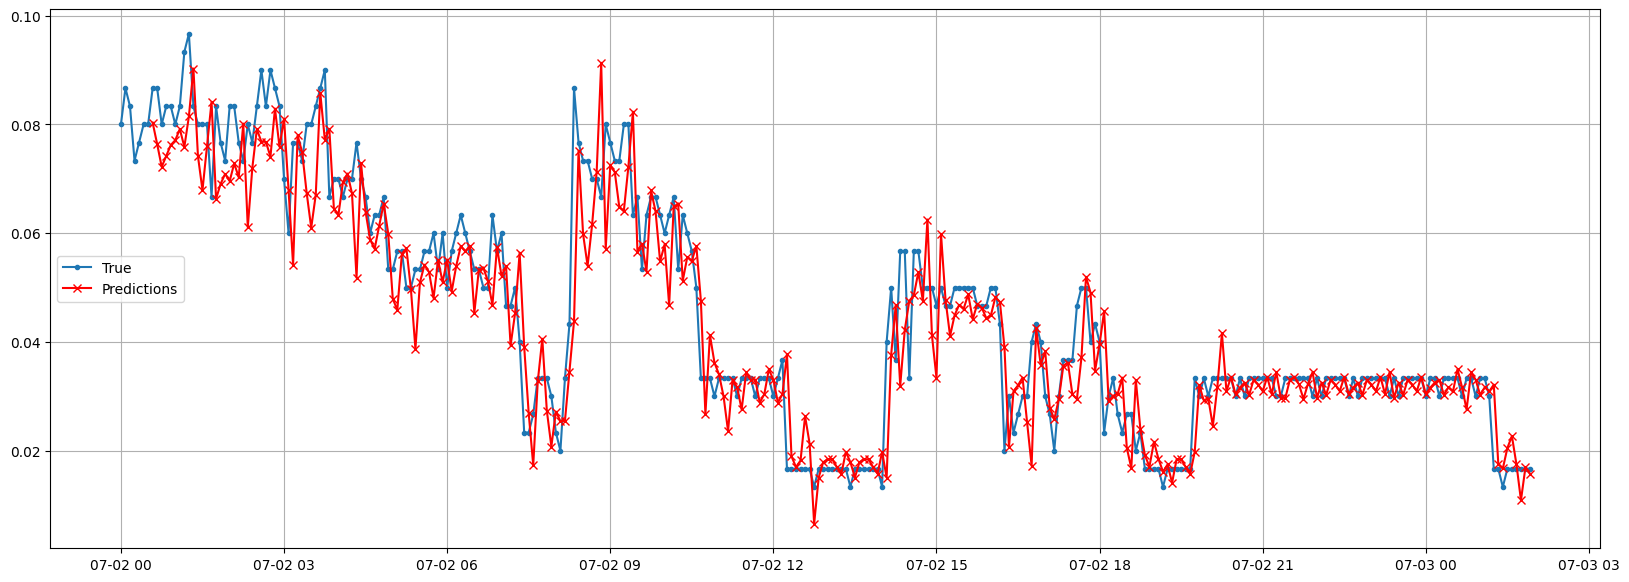

In [59]:
Y_pred = model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=test2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [60]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
fit_and_evaluate(univar_model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.6600e-04 - mae: 0.0249 - val_loss: 3.4287e-04 - val_mae: 0.0180
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.7725e-04 - mae: 0.0202 - val_loss: 2.8479e-04 - val_mae: 0.0166
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.3686e-04 - mae: 0.0190 - val_loss: 2.6257e-04 - val_mae: 0.0155
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.1259e-04 - mae: 0.0181 - val_loss: 2.3512e-04 - val_mae: 0.0155
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3.0076e-04 - mae: 0.0177 - val_loss: 2.2499e-04 - val_mae: 0.0145
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.9509e-04 - mae: 0.0175 - val_loss: 2.3099e-04 - val_mae: 0.0140
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.8785e-04 - mae: 0.0172 - val_loss: 2.3681e-04 - val_mae: 0.0169
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 2.8094e-04 - mae: 0.0170 - val_loss: 2.0802e-04 - val_mae

13386.125676333904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


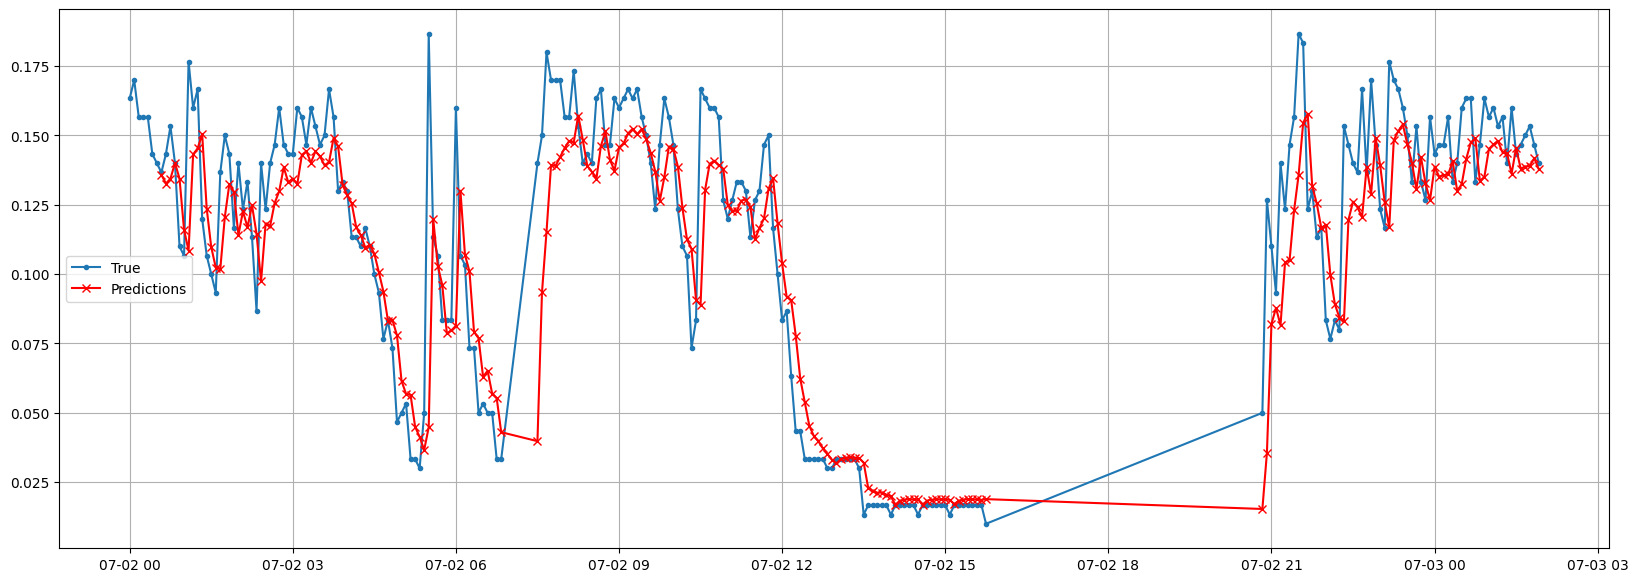

In [62]:
Y_pred = univar_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [63]:
fit_and_evaluate(univar_model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.1166e-04 - mae: 0.0072 - val_loss: 2.7203e-05 - val_mae: 0.0049
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.0759e-04 - mae: 0.0070 - val_loss: 3.0233e-05 - val_mae: 0.0050
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.0595e-04 - mae: 0.0070 - val_loss: 2.5151e-05 - val_mae: 0.0052
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.0369e-04 - mae: 0.0068 - val_loss: 2.8234e-05 - val_mae: 0.0049
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.9790e-04 - mae: 0.0067 - val_loss: 2.5007e-05 - val_mae: 0.0049
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 2.0189e-04 - mae: 0.0068 - val_loss: 2.7259e-05 - val_mae: 0.0048
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.0066e-04 - mae: 0.0069 - val_loss: 2.5244e-05 - val_mae: 0.0047
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 2.0356e-04 - mae: 0.0070 - val_loss: 2.5862e-05 - val_mae

4706.432577222586

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


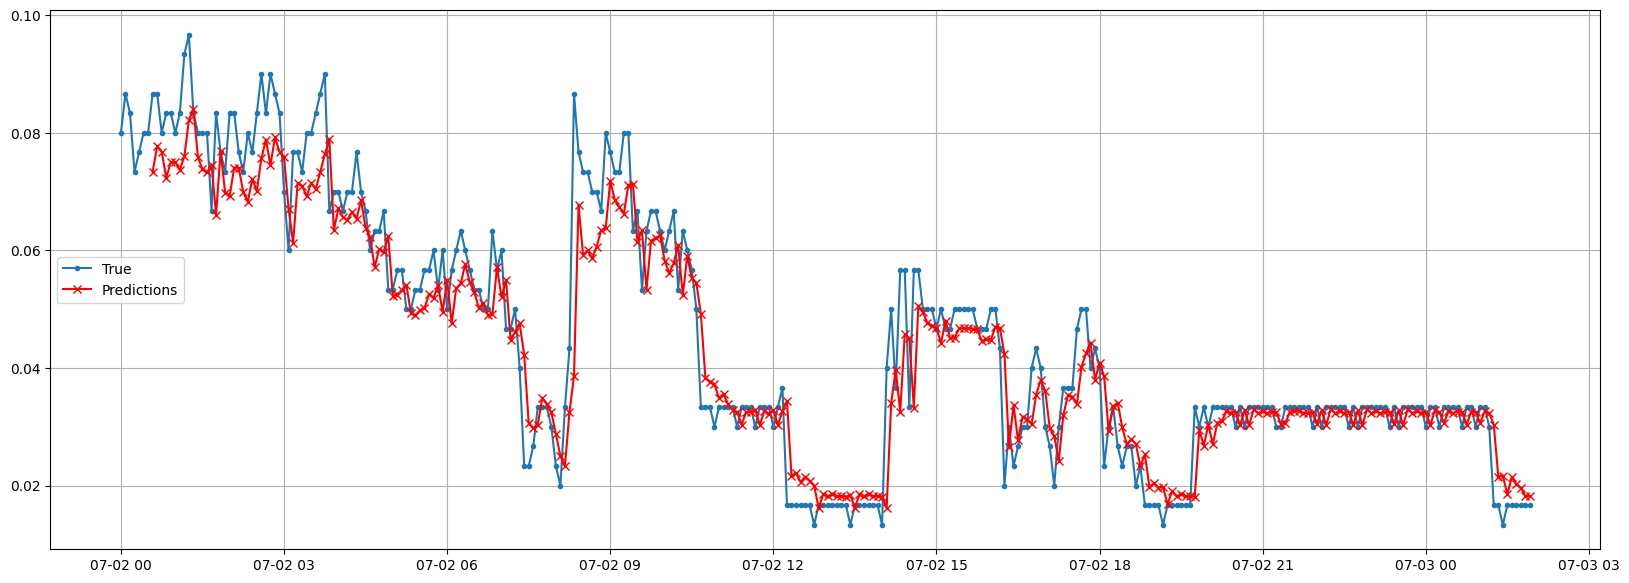

In [64]:
Y_pred = univar_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [65]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [66]:
fit_and_evaluate(deep_model, train_ds1, valid_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 0.0108 - mae: 0.0593 - val_loss: 3.3950e-04 - val_mae: 0.0186
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 3.8801e-04 - mae: 0.0208 - val_loss: 3.1301e-04 - val_mae: 0.0172
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 3.3982e-04 - mae: 0.0193 - val_loss: 2.5508e-04 - val_mae: 0.0174
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 3.0877e-04 - mae: 0.0182 - val_loss: 2.5234e-04 - val_mae: 0.0150
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.9628e-04 - mae: 0.0177 - val_loss: 2.0596e-04 - val_mae: 0.0140
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.8947e-04 - mae: 0.0173 - val_loss: 2.0935e-04 - val_mae: 0.0152
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 2.8012e-04 - mae: 0.0169 - val_loss: 2.4811e-04 - val_mae: 0.0179
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 2.8599e-04 - mae: 0.0173 - val_loss: 1.9314e-04 - v

12814.189307391644

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


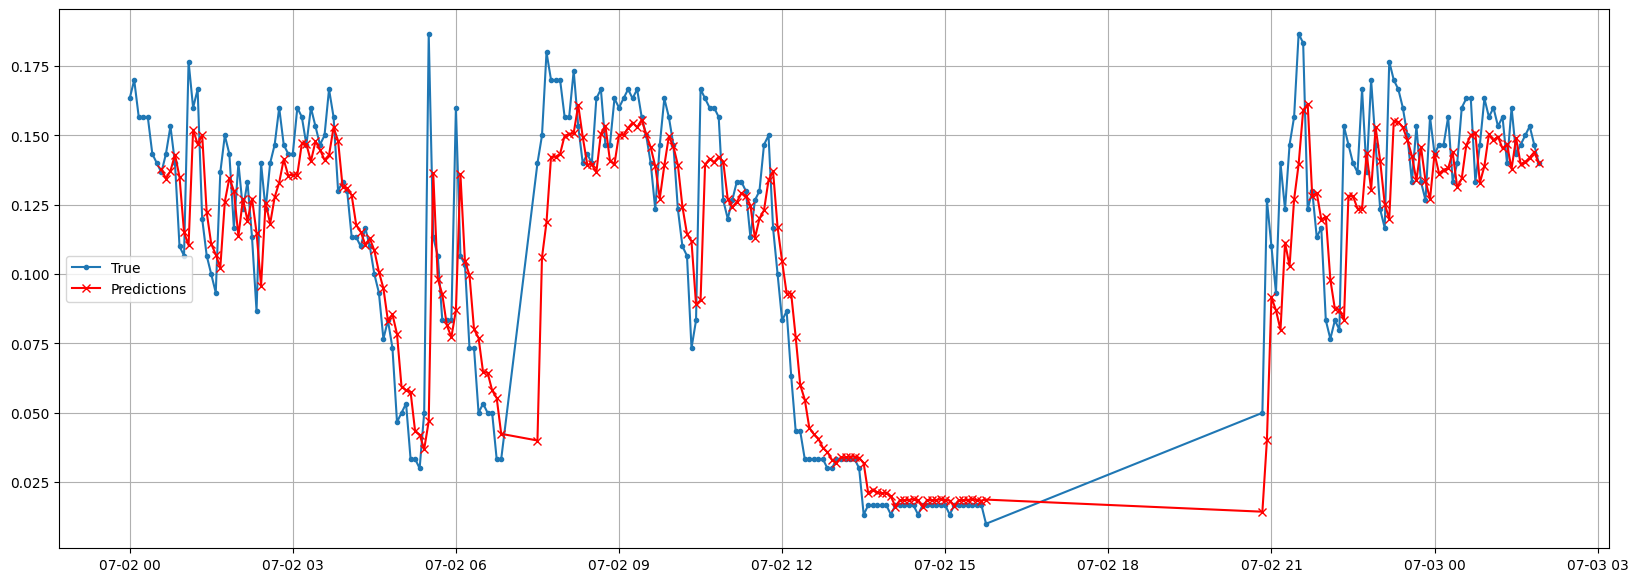

In [67]:
Y_pred = deep_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [68]:
fit_and_evaluate(deep_model, train_ds2, valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 2.1245e-04 - mae: 0.0080 - val_loss: 3.3429e-05 - val_mae: 0.0059
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 2.0353e-04 - mae: 0.0074 - val_loss: 2.3469e-05 - val_mae: 0.0051
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.0974e-04 - mae: 0.0084 - val_loss: 2.6994e-05 - val_mae: 0.0049
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.0581e-04 - mae: 0.0085 - val_loss: 2.2463e-05 - val_mae: 0.0044
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.0426e-04 - mae: 0.0080 - val_loss: 2.3148e-05 - val_mae: 0.0043
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.9312e-04 - mae: 0.0072 - val_loss: 2.3242e-05 - val_mae: 0.0050
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 2.0354e-04 - mae: 0.0080 - val_loss: 5.3078e-05 - val_mae: 0.0085
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.9611e-04 - mae: 0.0078 - val_loss: 2.3059e-0

4348.939750343561

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


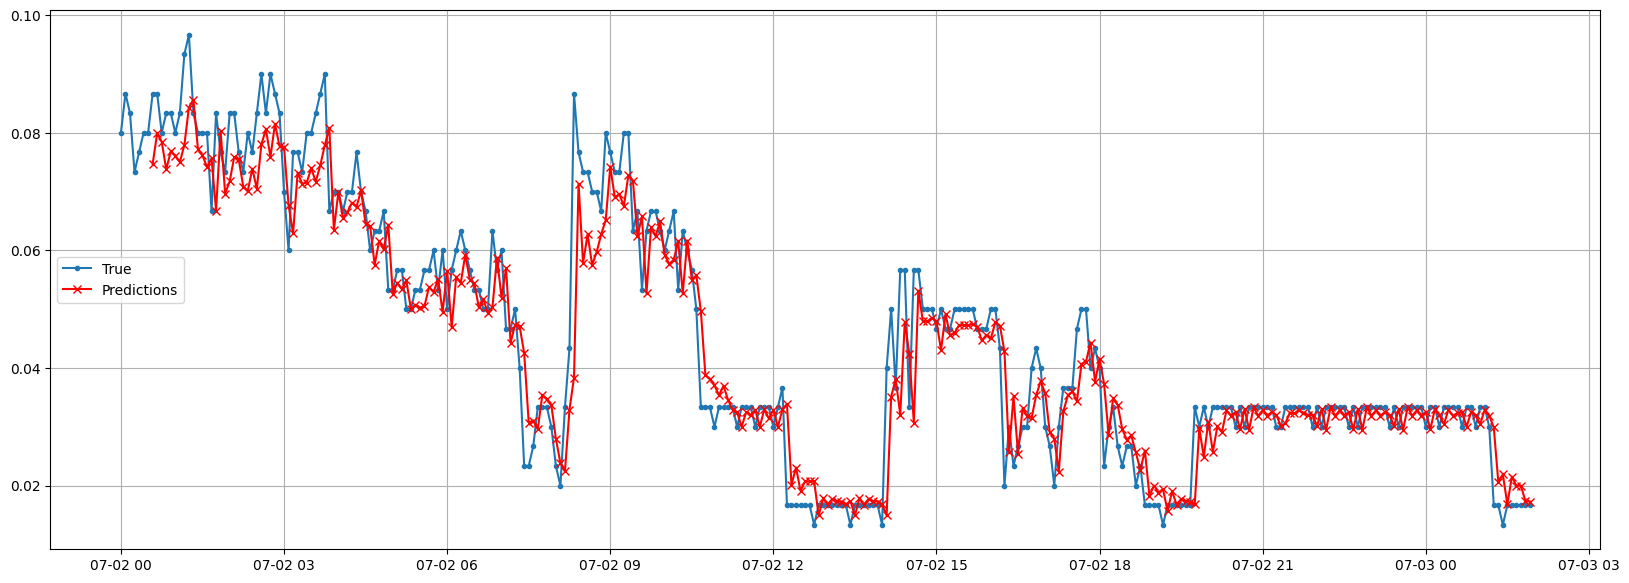

In [69]:
Y_pred = deep_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

### Multivariate Series

In [70]:
# ENDPOINT 1:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=train1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=valid1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=test1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [71]:
# ENDPOINT 2:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=train2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=valid2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=test2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [72]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
fit_and_evaluate(mulvar_model, train_mulvar_ds1, valid_mulvar_ds1)

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0149 - mae: 0.0967 - val_loss: 6.9169e-04 - val_mae: 0.0258
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 7.9465e-04 - mae: 0.0286 - val_loss: 4.1653e-04 - val_mae: 0.0203
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 5.3248e-04 - mae: 0.0231 - val_loss: 3.4424e-04 - val_mae: 0.0183
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.3844e-04 - mae: 0.0210 - val_loss: 3.0132e-04 - val_mae: 0.0172
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 3.8577e-04 - mae: 0.0196 - val_loss: 2.5205e-04 - val_mae: 0.0150
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.5718e-04 - mae: 0.0190 - val_loss: 2.3436e-04 - val_mae: 0.0144
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.3576e-04 - mae: 0.0183 - val_loss: 2.2131e-04 - val_mae: 0.0140
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 3.1878e-04 - mae: 0.0178 - val_loss: 2.1514e-04 - val_mae: 0.

13335.910625755787

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


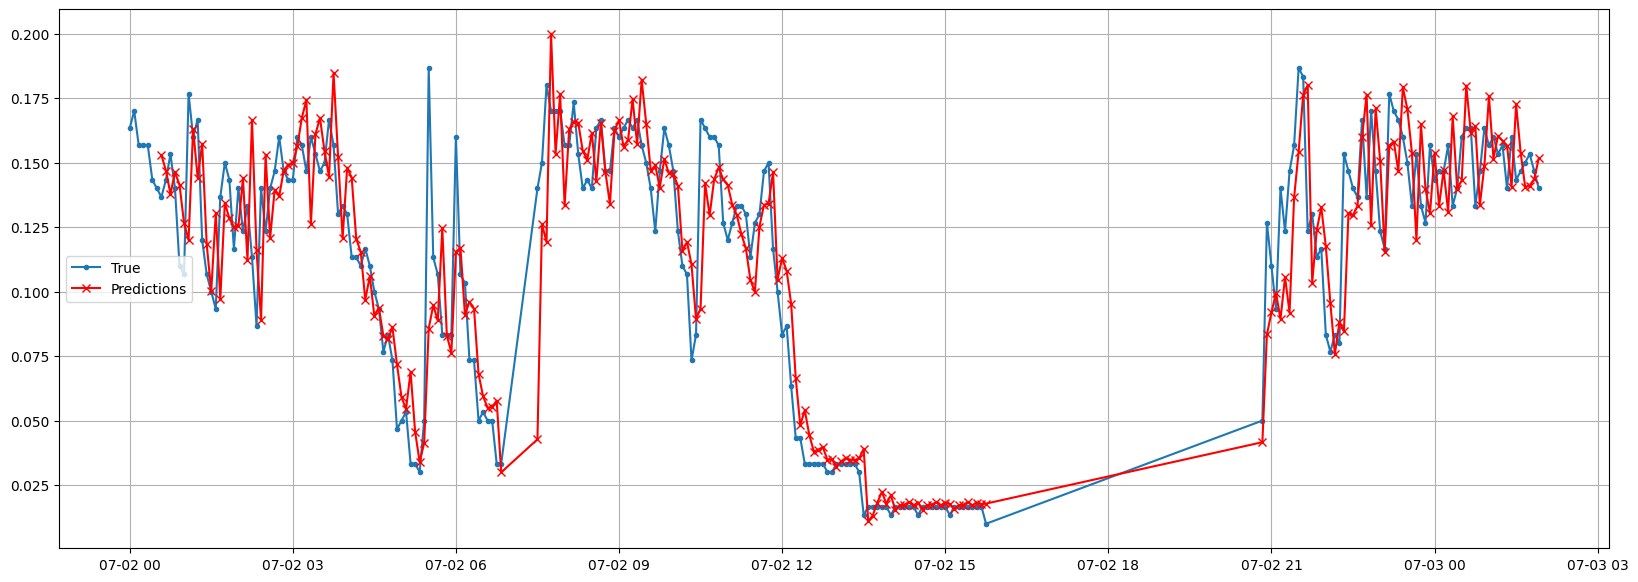

In [74]:
Y_pred = mulvar_model.predict(test_mulvar_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [75]:
fit_and_evaluate(mulvar_model, train_mulvar_ds2, valid_mulvar_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.7185e-04 - mae: 0.0175 - val_loss: 1.1643e-04 - val_mae: 0.0097
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.7677e-04 - mae: 0.0117 - val_loss: 7.9378e-05 - val_mae: 0.0082
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.4447e-04 - mae: 0.0107 - val_loss: 6.7062e-05 - val_mae: 0.0074
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.1961e-04 - mae: 0.0099 - val_loss: 4.9411e-05 - val_mae: 0.0070
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.1086e-04 - mae: 0.0094 - val_loss: 5.5323e-05 - val_mae: 0.0067
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 2.0539e-04 - mae: 0.0090 - val_loss: 3.8744e-05 - val_mae: 0.0062
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.9679e-04 - mae: 0.0087 - val_loss: 3.7850e-05 - val_mae: 0.0058
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.9327e-04 - mae: 0.0087 - val_loss: 3.3674e-05 - val_mae:

5202.517379075289

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


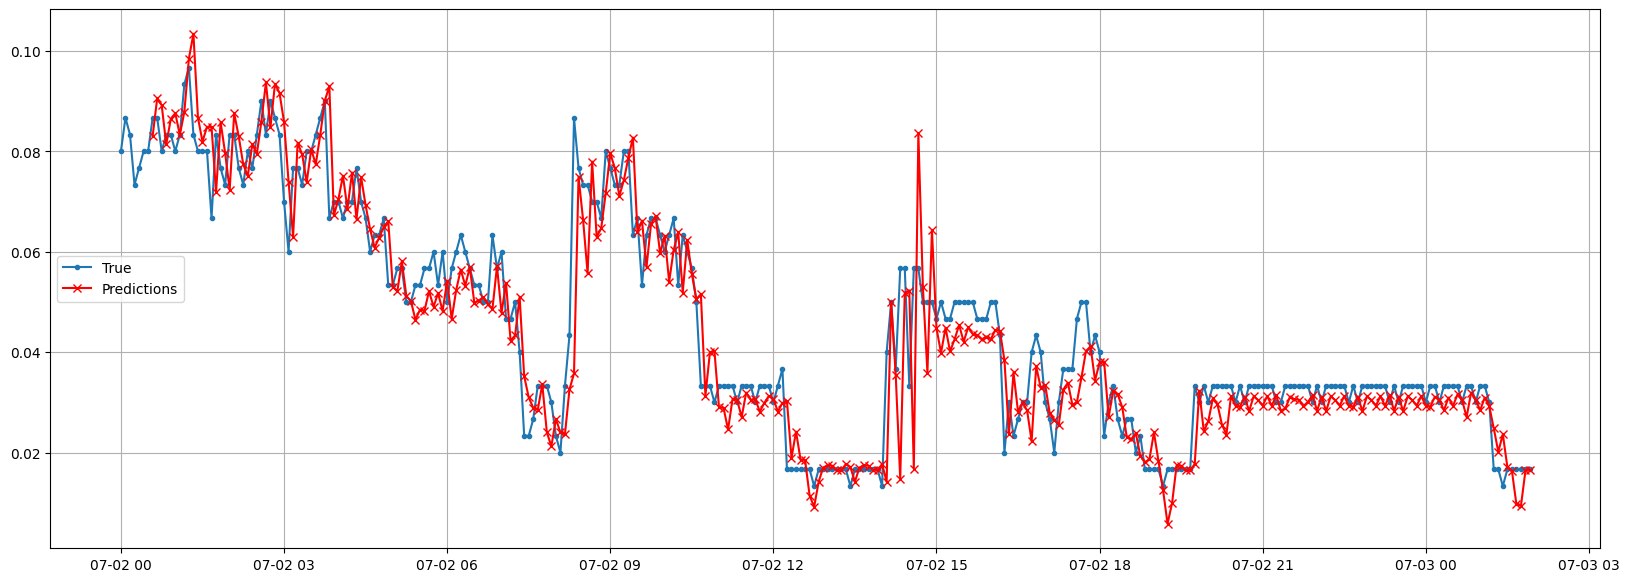

In [76]:
Y_pred = mulvar_model.predict(test_mulvar_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


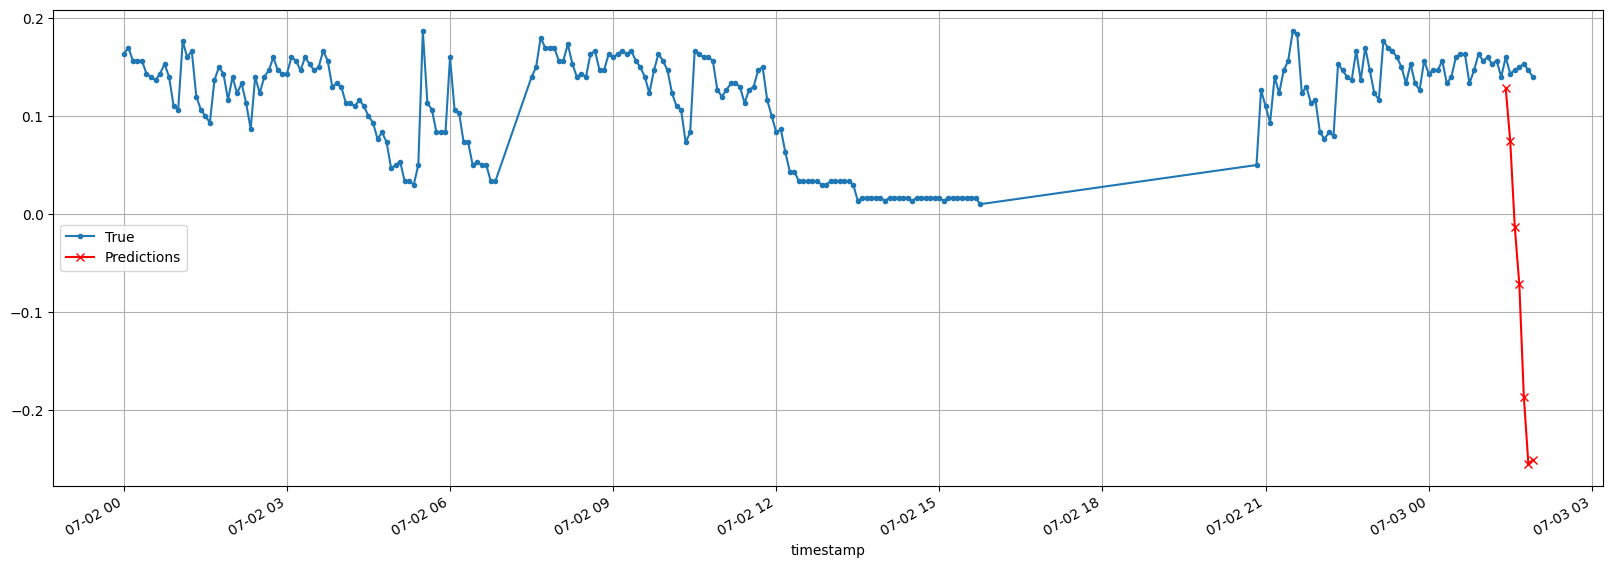

In [77]:
X = ts1[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


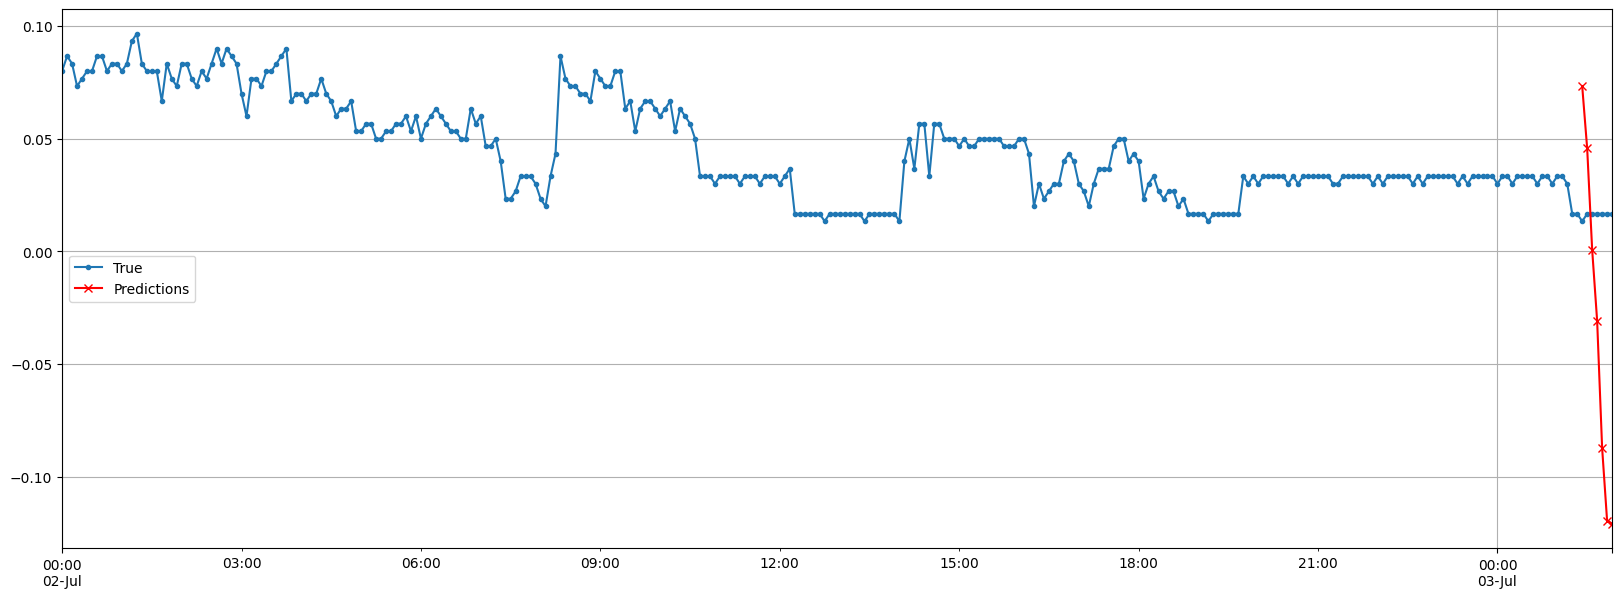

In [78]:
X = ts2[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [79]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

In [80]:
# ENDPOINT 1:

ahead_train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [81]:
# ENDPOINT 2:

ahead_train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [82]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
fit_and_evaluate(ahead_model, ahead_train_ds1, ahead_valid_ds1)

Epoch 1/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3192 - mae: 0.6396 - val_loss: 0.1912 - val_mae: 0.4549
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2925 - mae: 0.6009 - val_loss: 0.1913 - val_mae: 0.4585
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2916 - mae: 0.6002 - val_loss: 0.1901 - val_mae: 0.4542
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2904 - mae: 0.5987 - val_loss: 0.1886 - val_mae: 0.4454
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2901 - mae: 0.5985 - val_loss: 0.1891 - val_mae: 0.4558
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2898 - mae: 0.5982 - val_loss: 0.1876 - val_mae: 0.4488
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.2899 - mae: 0.5984 - val_loss: 0.1877 - val_mae: 0.4473
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2895 - mae: 0.5974 - val_loss: 0.1877 - val_mae: 0.4399
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - lo

439903.6467075348

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


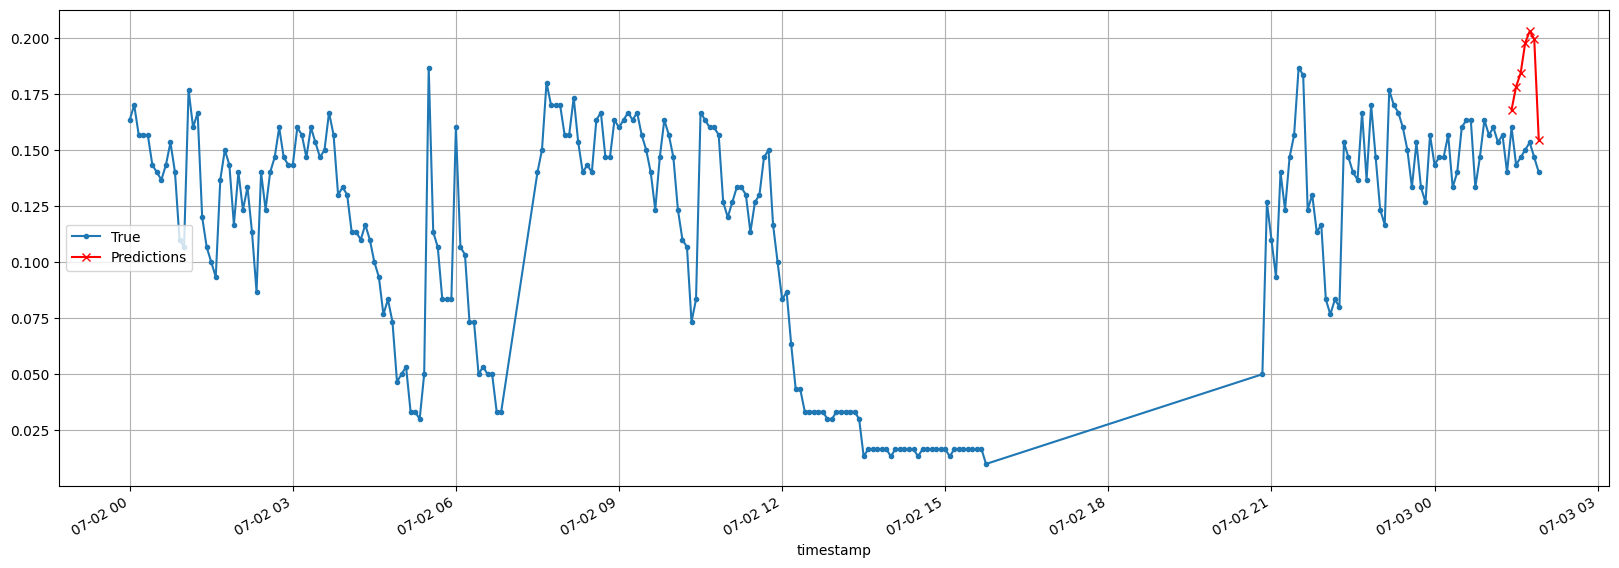

In [84]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [85]:
fit_and_evaluate(ahead_model, ahead_train_ds2, ahead_valid_ds2)

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1949 - mae: 0.3376 - val_loss: 0.0348 - val_mae: 0.1664
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1453 - mae: 0.2871 - val_loss: 0.0264 - val_mae: 0.0880
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1337 - mae: 0.2663 - val_loss: 0.0246 - val_mae: 0.0888
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1352 - mae: 0.2679 - val_loss: 0.0262 - val_mae: 0.1234
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1523 - mae: 0.2887 - val_loss: 0.0248 - val_mae: 0.1092
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1310 - mae: 0.2637 - val_loss: 0.0246 - val_mae: 0.1081
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1334 - mae: 0.2669 - val_loss: 0.0239 - val_mae: 0.0780
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1290 - mae: 0.2619 - val_loss: 0.0243 - val_mae: 0.0974
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

75765.03604650497

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


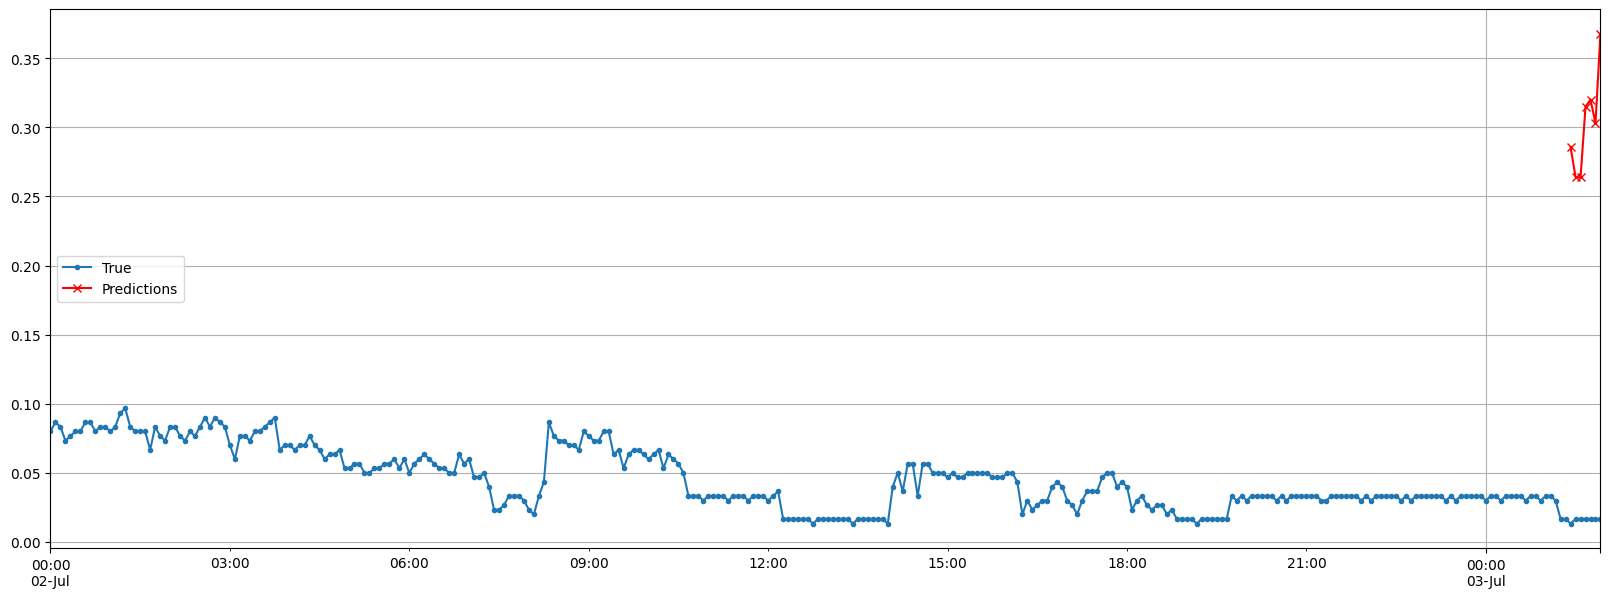

In [86]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [87]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [88]:
seq2seq_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght, ahead=prediction_lenght)

seq2seq_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [89]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [90]:
fit_and_evaluate(seq2seq_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    695/Unknown 6s 7ms/step - loss: 0.3639 - mae: 0.7005

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.3631 - mae: 0.6995 - val_loss: 0.1872 - val_mae: 0.4419
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3429 - mae: 0.6695 - val_loss: 0.1866 - val_mae: 0.4395
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.3424 - mae: 0.6685 - val_loss: 0.1862 - val_mae: 0.4386
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.3422 - mae: 0.6676 - val_loss: 0.1861 - val_mae: 0.4389
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.3403 - mae: 0.6654 - val_loss: 0.1860 - val_mae: 0.4400
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3396 - mae: 0.6646 - val_loss: 0.1858 - val_mae: 0.4385
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3396 - mae: 0.6645 - val_loss: 0.1857 - val_mae: 0.4385
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3396 - mae: 0.6642 - val_loss: 0.1856 - val_mae: 0.4369
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0

436882.9131126404

In [91]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test1)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test1.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test1["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
MAE for +1: 371,292
MAE for +2: 321,484
MAE for +3: 328,331
MAE for +4: 359,538
MAE for +5: 400,469
MAE for +6: 298,533
MAE for +7: 354,795


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


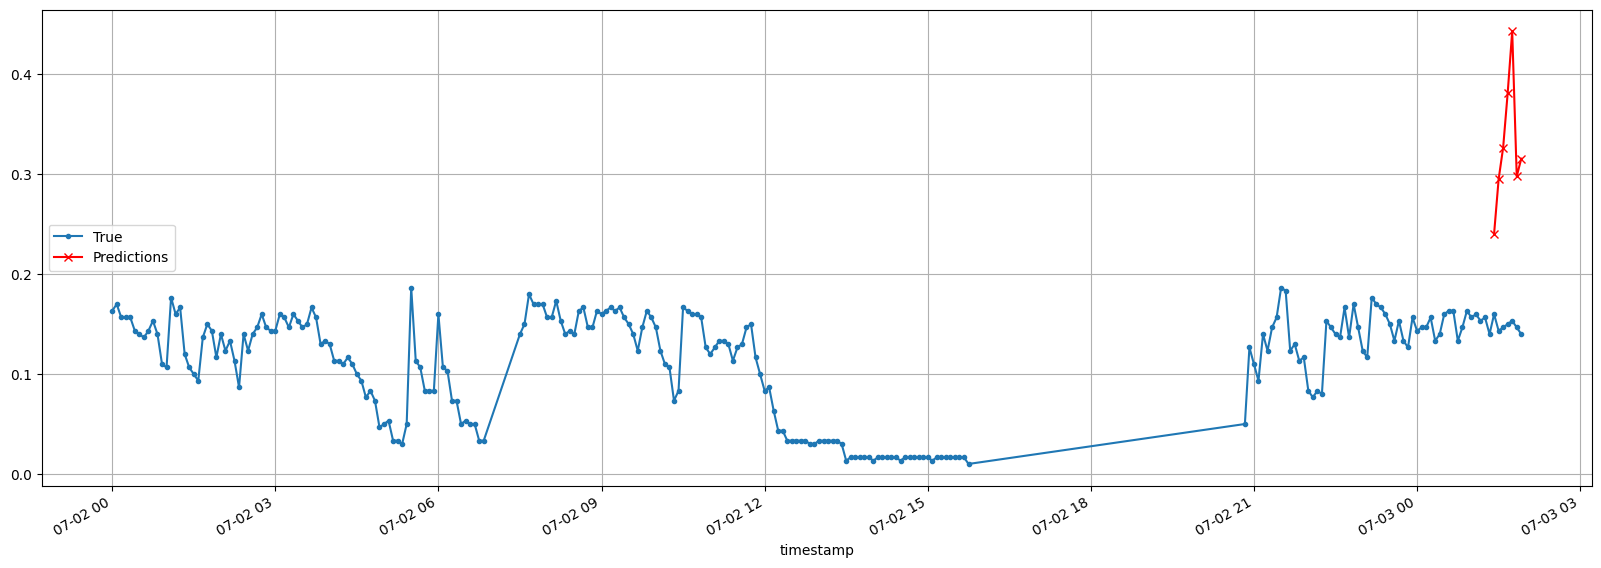

In [92]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [93]:
fit_and_evaluate(seq2seq_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    579/Unknown 8s 12ms/step - loss: 0.1711 - mae: 0.3113

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1717 - mae: 0.3120 - val_loss: 0.0466 - val_mae: 0.1645
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1551 - mae: 0.2968 - val_loss: 0.0574 - val_mae: 0.1898
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1535 - mae: 0.2947 - val_loss: 0.0534 - val_mae: 0.1683
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1506 - mae: 0.2928 - val_loss: 0.0470 - val_mae: 0.1471
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1497 - mae: 0.2893 - val_loss: 0.0533 - val_mae: 0.1567
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.1482 - mae: 0.2861 - val_loss: 0.0458 - val_mae: 0.1367
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1473 - mae: 0.2828 - val_loss: 0.0382 - val_mae: 0.1161
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1438 - mae: 0.2761 - val_loss: 0.0358 - val_mae: 0.1088
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss:

107991.36757850647

In [94]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test2)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test2.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test2["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE for +1: 233,493
MAE for +2: 249,320
MAE for +3: 257,081
MAE for +4: 256,795
MAE for +5: 257,538
MAE for +6: 238,879
MAE for +7: 231,257


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


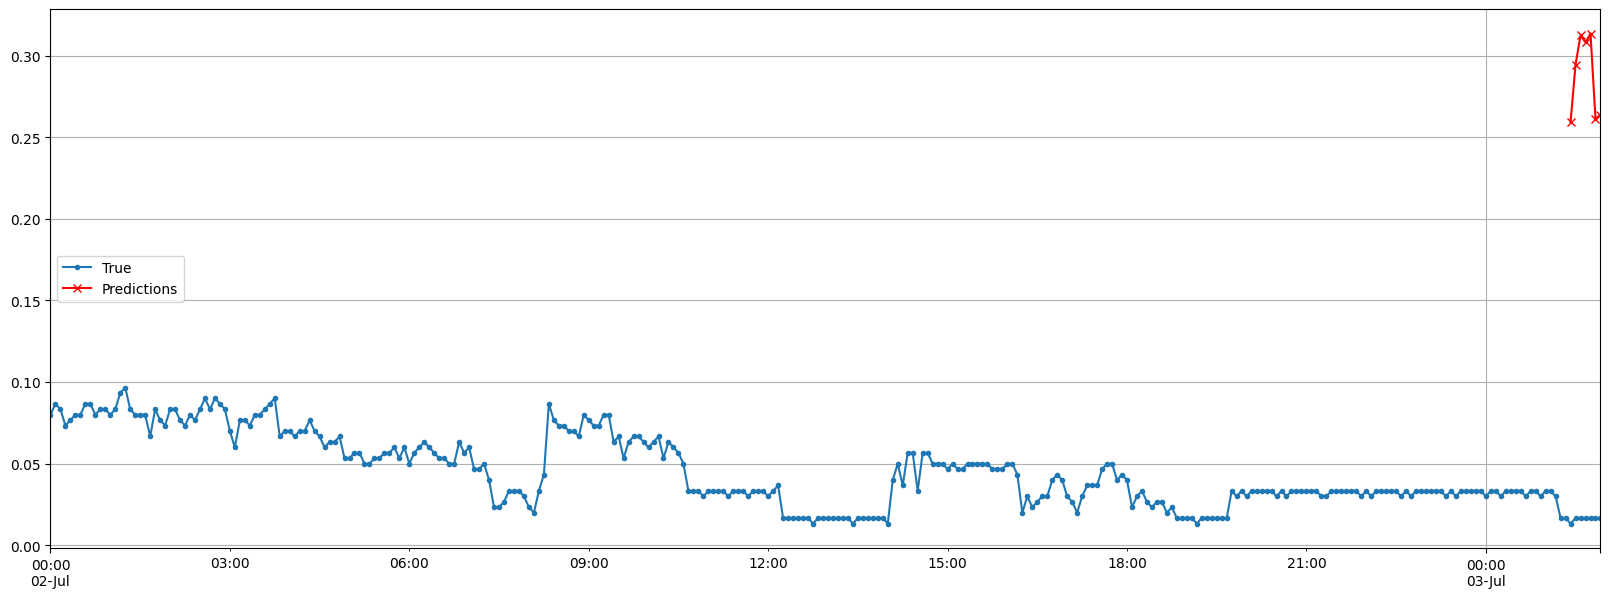

In [95]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [96]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [97]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [98]:
fit_and_evaluate(custom_ln_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    698/Unknown 14s 17ms/step - loss: 0.3747 - mae: 0.7106

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.3742 - mae: 0.7100 - val_loss: 0.1909 - val_mae: 0.4489
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.3463 - mae: 0.6723 - val_loss: 0.1883 - val_mae: 0.4455
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3432 - mae: 0.6679 - val_loss: 0.1871 - val_mae: 0.4424
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3428 - mae: 0.6671 - val_loss: 0.1866 - val_mae: 0.4411
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3423 - mae: 0.6662 - val_loss: 0.1863 - val_mae: 0.4410
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3412 - mae: 0.6647 - val_loss: 0.1862 - val_mae: 0.4415
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3420 - mae: 0.6658 - val_loss: 0.1860 - val_mae: 0.4409
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3403 - mae: 0.6634 - val_loss: 0.1858 - val_mae: 0.4400
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - 

439232.4984073639

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


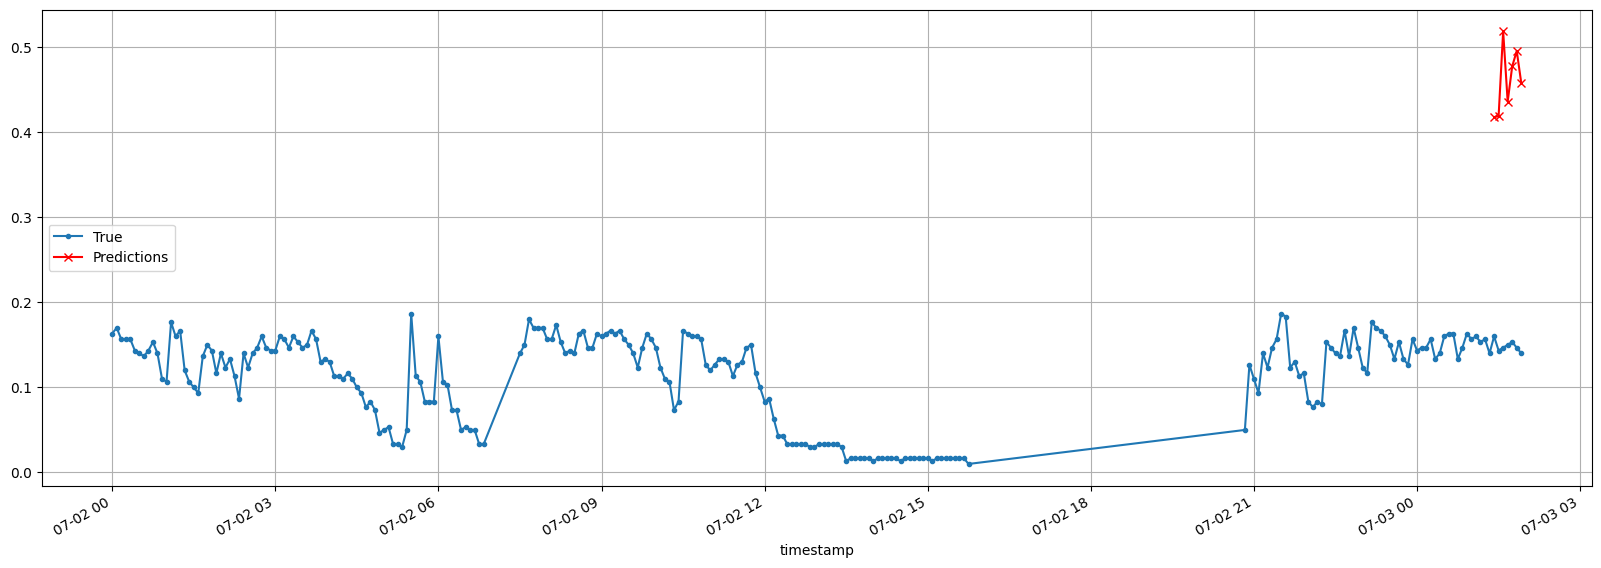

In [99]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [100]:
fit_and_evaluate(custom_ln_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    582/Unknown 8s 10ms/step - loss: 0.1670 - mae: 0.3085

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1677 - mae: 0.3094 - val_loss: 0.0343 - val_mae: 0.1088
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.1617 - mae: 0.2987 - val_loss: 0.0408 - val_mae: 0.1243
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1508 - mae: 0.2860 - val_loss: 0.0393 - val_mae: 0.1204
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1428 - mae: 0.2748 - val_loss: 0.0411 - val_mae: 0.1188
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1438 - mae: 0.2754 - val_loss: 0.0365 - val_mae: 0.1093
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1411 - mae: 0.2705 - val_loss: 0.0330 - val_mae: 0.0980
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1407 - mae: 0.2693 - val_loss: 0.0294 - val_mae: 0.0834
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.1398 - mae: 0.2684 - val_loss: 0.0273 - val_mae: 0.0774
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - 

72351.26942396164

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


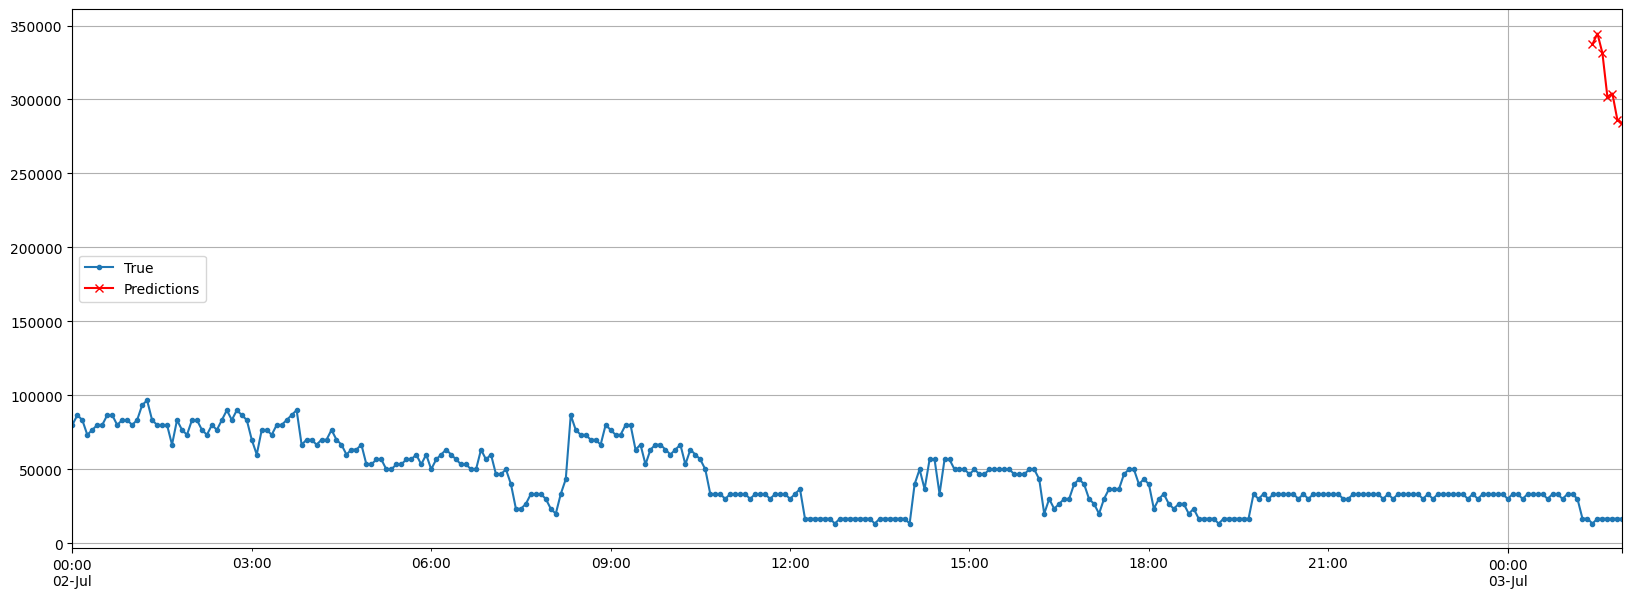

In [101]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2 * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [102]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [103]:
fit_and_evaluate(lstm, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    694/Unknown 8s 9ms/step - loss: 0.3585 - mae: 0.7133

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3577 - mae: 0.7122 - val_loss: 0.1883 - val_mae: 0.4414
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.3445 - mae: 0.6731 - val_loss: 0.1882 - val_mae: 0.4397
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.3438 - mae: 0.6718 - val_loss: 0.1883 - val_mae: 0.4395
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3425 - mae: 0.6703 - val_loss: 0.1881 - val_mae: 0.4373
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3422 - mae: 0.6697 - val_loss: 0.1880 - val_mae: 0.4374
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3430 - mae: 0.6706 - val_loss: 0.1879 - val_mae: 0.4372
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3418 - mae: 0.6691 - val_loss: 0.1877 - val_mae: 0.4364
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.3421 - mae: 0.6692 - val_loss: 0.1876 - val_mae: 0.4363
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - l

436265.5282020569

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


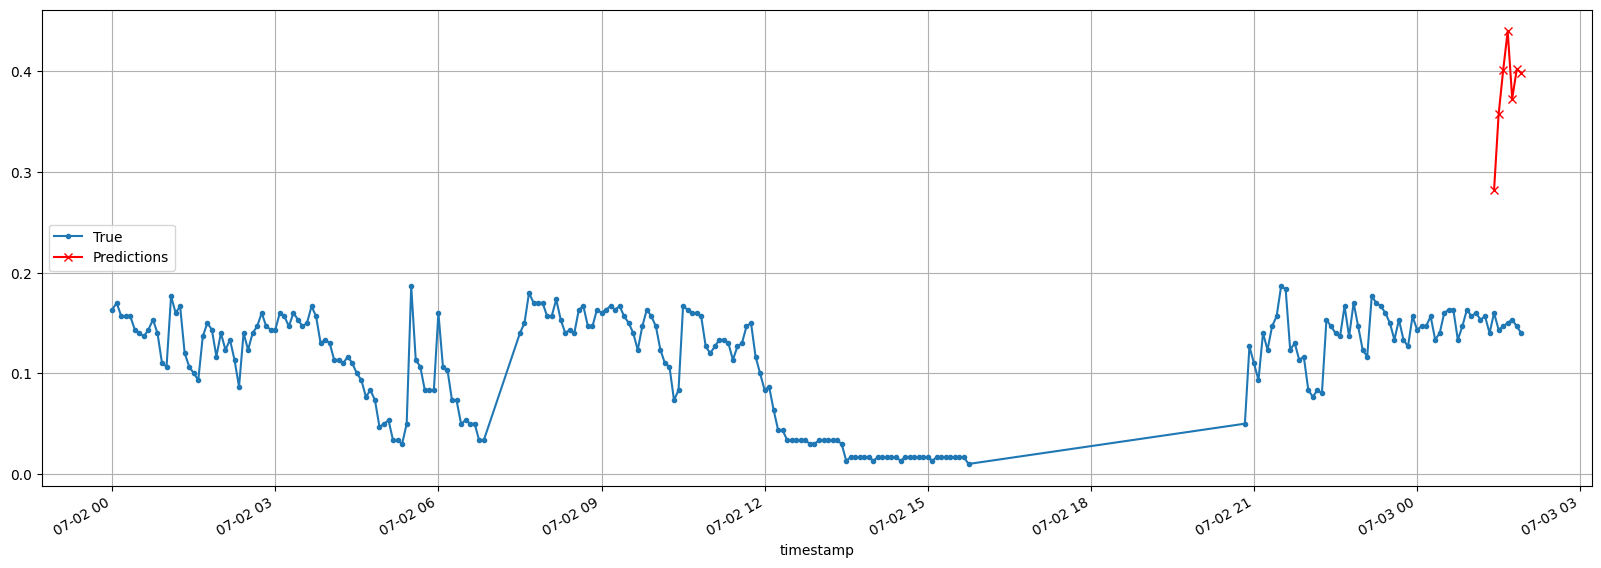

In [104]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [105]:
fit_and_evaluate(lstm, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    584/Unknown 7s 9ms/step - loss: 0.1637 - mae: 0.2999

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1641 - mae: 0.3006 - val_loss: 0.0318 - val_mae: 0.1289
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1498 - mae: 0.2888 - val_loss: 0.0345 - val_mae: 0.1449
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1457 - mae: 0.2825 - val_loss: 0.0401 - val_mae: 0.1574
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1490 - mae: 0.2828 - val_loss: 0.0378 - val_mae: 0.1485
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.1457 - mae: 0.2784 - val_loss: 0.0342 - val_mae: 0.1292
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1447 - mae: 0.2755 - val_loss: 0.0335 - val_mae: 0.1243
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1431 - mae: 0.2736 - val_loss: 0.0323 - val_mae: 0.1160
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1421 - mae: 0.2729 - val_loss: 0.0289 - val_mae: 0.0990
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lo

94161.80849075317

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


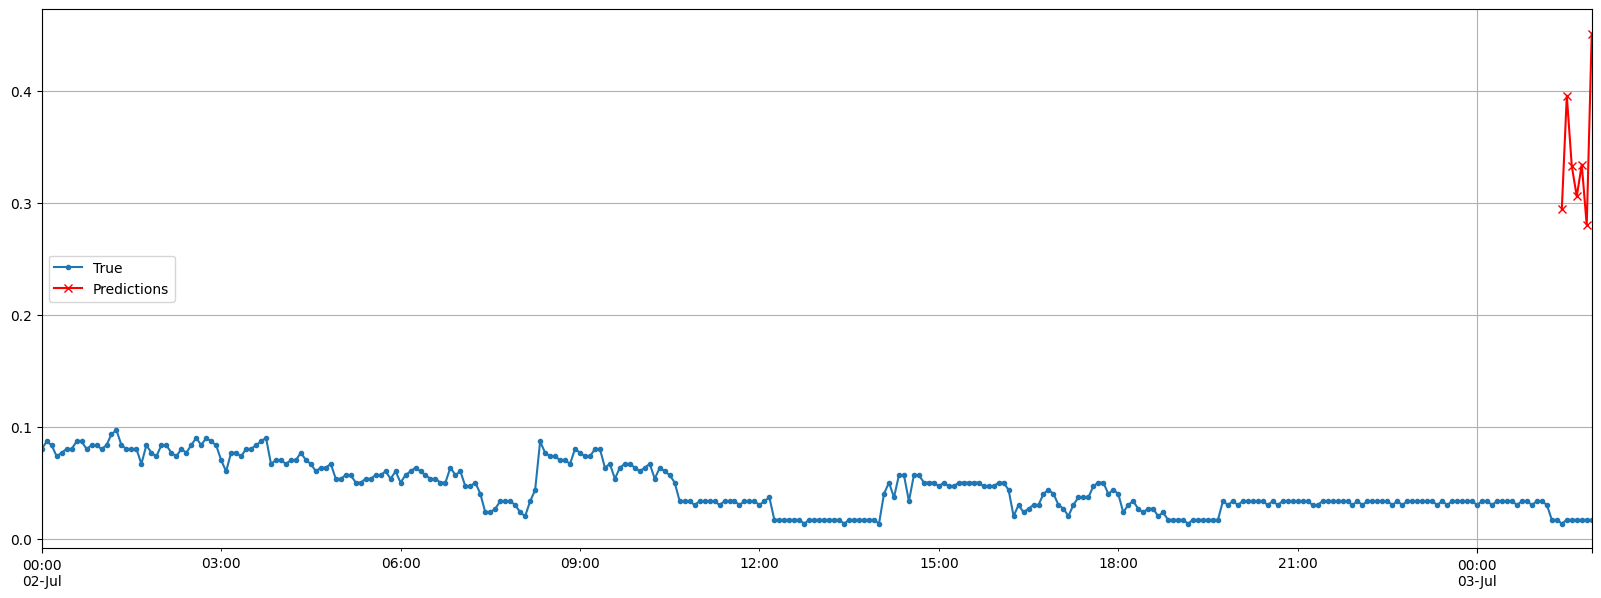

In [106]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [107]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
fit_and_evaluate(gru, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    700/Unknown 9s 10ms/step - loss: 0.3504 - mae: 0.6923

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.3502 - mae: 0.6919 - val_loss: 0.1863 - val_mae: 0.4383
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3439 - mae: 0.6728 - val_loss: 0.1864 - val_mae: 0.4370
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3423 - mae: 0.6702 - val_loss: 0.1863 - val_mae: 0.4350
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3417 - mae: 0.6691 - val_loss: 0.1862 - val_mae: 0.4350
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.3417 - mae: 0.6689 - val_loss: 0.1861 - val_mae: 0.4354
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.3411 - mae: 0.6681 - val_loss: 0.1859 - val_mae: 0.4345
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.3409 - mae: 0.6676 - val_loss: 0.1858 - val_mae: 0.4336
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3409 - mae: 0.6675 - val_loss: 0.1857 - val_mae: 0.4341
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - 

433178.45463752747

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


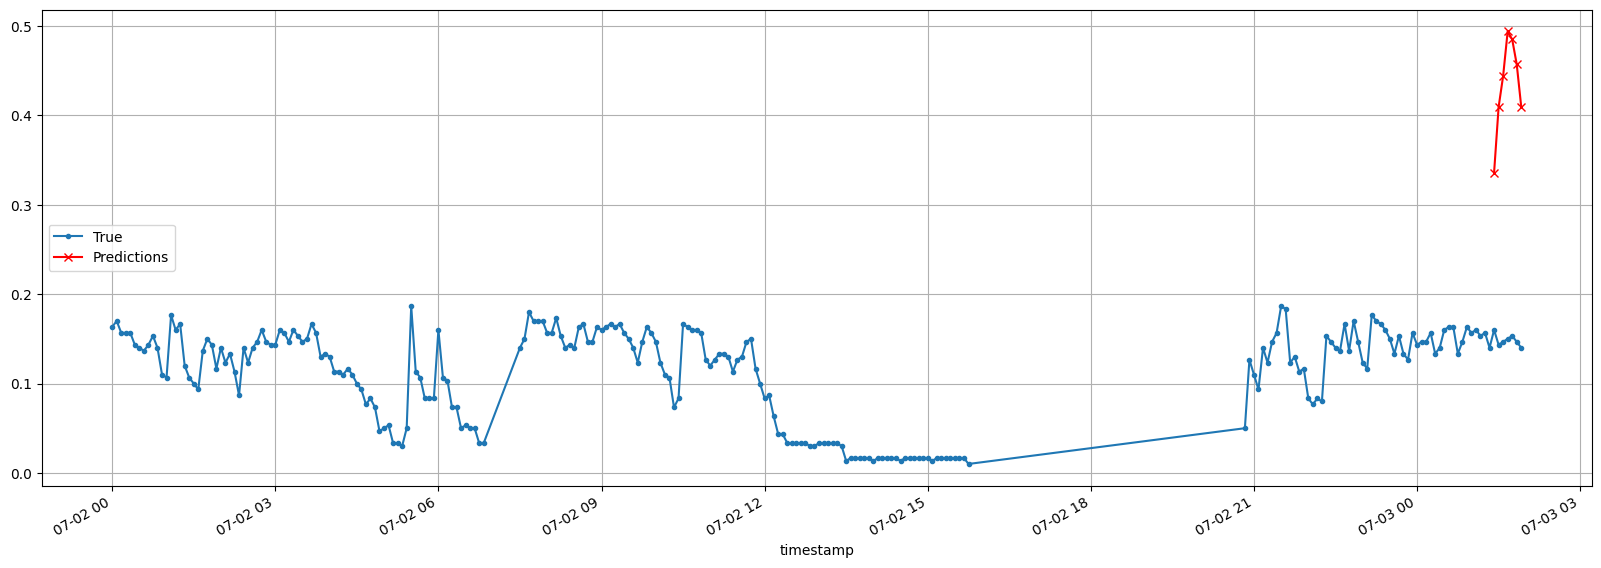

In [109]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [110]:
fit_and_evaluate(gru, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    588/Unknown 9s 13ms/step - loss: 0.1633 - mae: 0.3006

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1634 - mae: 0.3008 - val_loss: 0.0377 - val_mae: 0.1485
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.1533 - mae: 0.2911 - val_loss: 0.0410 - val_mae: 0.1567
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1536 - mae: 0.2896 - val_loss: 0.0418 - val_mae: 0.1537
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1513 - mae: 0.2845 - val_loss: 0.0370 - val_mae: 0.1317
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1475 - mae: 0.2794 - val_loss: 0.0356 - val_mae: 0.1218
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.1474 - mae: 0.2793 - val_loss: 0.0323 - val_mae: 0.1057
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1465 - mae: 0.2793 - val_loss: 0.0307 - val_mae: 0.0991
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1450 - mae: 0.2782 - val_loss: 0.0295 - val_mae: 0.0953
Epoch 9/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - lo

88065.52737951279

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


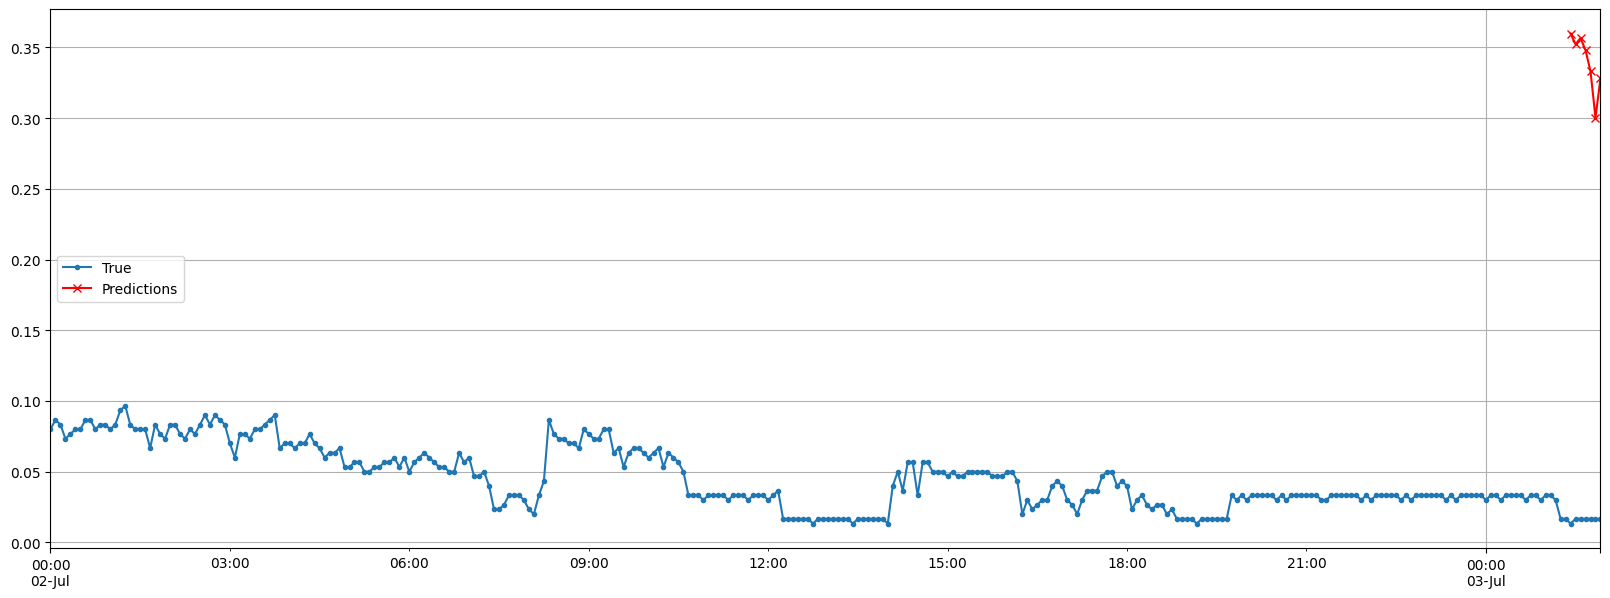

In [111]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [112]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [113]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
    697/Unknown 9s 11ms/step - loss: 0.3599 - mae: 0.6958

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3593 - mae: 0.6951 - val_loss: 0.1866 - val_mae: 0.4398
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3426 - mae: 0.6694 - val_loss: 0.1860 - val_mae: 0.4369
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3425 - mae: 0.6684 - val_loss: 0.1859 - val_mae: 0.4369
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.3403 - mae: 0.6659 - val_loss: 0.1858 - val_mae: 0.4364
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3410 - mae: 0.6667 - val_loss: 0.1856 - val_mae: 0.4351
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.3412 - mae: 0.6667 - val_loss: 0.1854 - val_mae: 0.4364
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3402 - mae: 0.6654 - val_loss: 0.1854 - val_mae: 0.4361
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3392 - mae: 0.6639 - val_loss: 0.1852 - val_mae: 0.4355
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - los

432016.84951782227

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


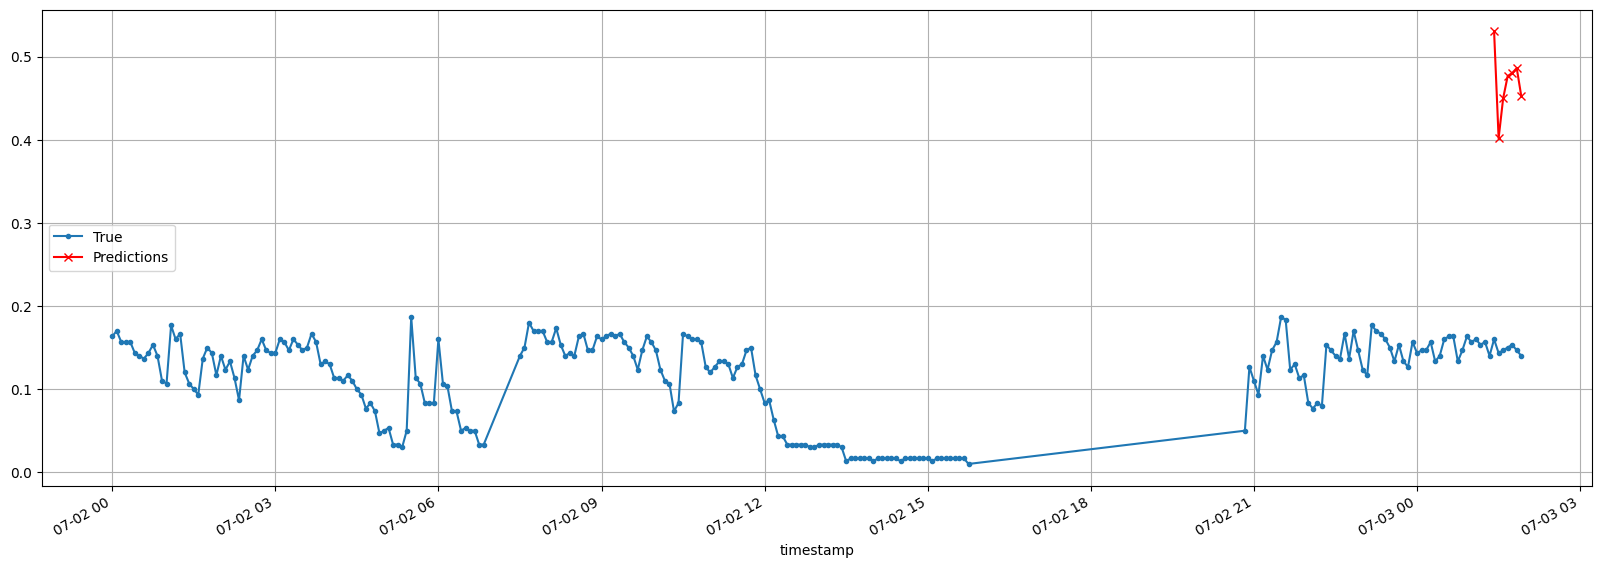

In [114]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
    580/Unknown 7s 10ms/step - loss: 0.1644 - mae: 0.3029

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


590/590 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1648 - mae: 0.3035 - val_loss: 0.0393 - val_mae: 0.1357
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1515 - mae: 0.2932 - val_loss: 0.0460 - val_mae: 0.1657
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.1484 - mae: 0.2882 - val_loss: 0.0421 - val_mae: 0.1478
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1457 - mae: 0.2832 - val_loss: 0.0407 - val_mae: 0.1374
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.1442 - mae: 0.2801 - val_loss: 0.0488 - val_mae: 0.1587
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1443 - mae: 0.2799 - val_loss: 0.0368 - val_mae: 0.1210
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.1422 - mae: 0.2752 - val_loss: 0.0380 - val_mae: 0.1276
Epoch 8/10


In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [ ]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

In [ ]:
# ENDPOINT 1:
longer_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght*2)
longer_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght*2)
downsampled_train1 = longer_train1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid1 = longer_valid1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test1 = longer_test1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train1, downsampled_valid1)

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
# ENDPOINT 2:
longer_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght*2)
longer_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght*2)
downsampled_train2 = longer_train2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid2 = longer_valid2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test2 = longer_test2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train2, downsampled_valid2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("Endpoint 1:")
result1 = adfuller(train1['avg_invocations_rate'])
print('ADF Statistic:', result1[0])
print('p-value:', result1[1])
print("Endpoint 2:")
result2 = adfuller(train2['avg_invocations_rate'])
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])

In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train1['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train1['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train2['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train2['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [ ]:
trimmed_valid1 = ts1.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid1, order=(1,1,1))
arima = arima.fit()

In [ ]:
# Forecasting
forecast1 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts1.index, ts1, label='Observed')
plt.plot(pd.date_range(trimmed_valid1.index[-1], periods=prediction_lenght, freq=freq), forecast1, label='Forecast', color='red')
plt.axvline(trimmed_valid1.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [ ]:
trimmed_valid2 = ts2.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid2, order=(1,1,1))
arima = arima.fit()

In [ ]:
# Forecasting
forecast2 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts2.index, ts2, label='Observed')
plt.plot(pd.date_range(trimmed_valid2.index[-1], periods=prediction_lenght, freq=freq), forecast2, label='Forecast', color='red')
plt.axvline(trimmed_valid2.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(forecast1)